## 1. Setup and Installation
Install the necessary libraries: `roboflow` for dataset management and `ultralytics` for the model.

In [1]:
!pip install roboflow ultralytics matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 92.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11


## 2. Download Data from Roboflow
We will download the dataset using the Roboflow API.

In [5]:
from roboflow import Roboflow
import os

# --- CONFIGURATION ---
API_KEY = 'fNh37dV1D0lUqlJYGKHa'
WORKSPACE = "jennifers-almost-paradise"
PROJECT = "jennifer_week3"
VERSION = 1 # We assume version 1, change if you are using a specific version
# ---------------------

try:
    rf = Roboflow(api_key=API_KEY)
    project = rf.workspace(WORKSPACE).project(PROJECT)
    dataset = project.version(VERSION).download("folder")
    dataset_path = dataset.location
    print(f"\n Dataset downloaded to: {dataset_path}")
except Exception as e:
    print("\n Error downloading dataset. Please check your API Key and Project permissions.")
    print(e)

loading Roboflow workspace...
loading Roboflow project...
Exporting format folder in progress : 85.0%
Version export complete for folder format



Extracting Dataset Version Zip to Jennifer_Week3-1 in folder:: 100%|██████████| 247/247 [00:00<00:00, 10795.76it/s]


 Dataset downloaded to: /content/Jennifer_Week3-1


## 3. Dataset Exploration & Analysis
Here we write a custom script to walk through the folders, count the images, and analyze the distribution.

Analyzing dataset at: /content/Jennifer_Week3-1...

 Dataset Statistics:
Total Images: 236
Classes Detected: ['PNEUMONIA' 'NORMAL']

Breakdown by Split and Class:
Split      test  train  valid
Class                        
NORMAL       10     99     10
PNEUMONIA    10     97     10


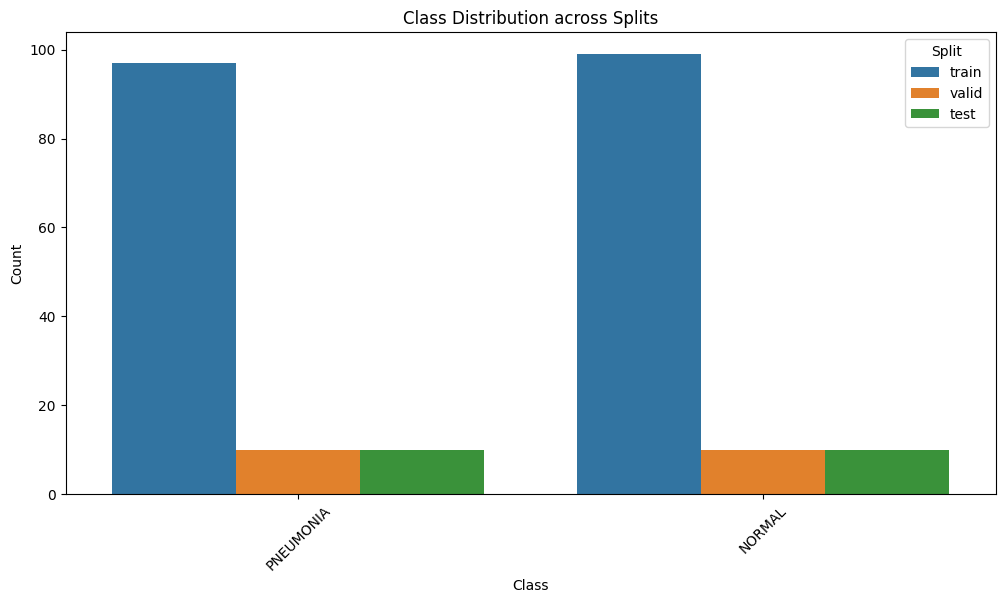


 Sample Images (One per class from Train split):


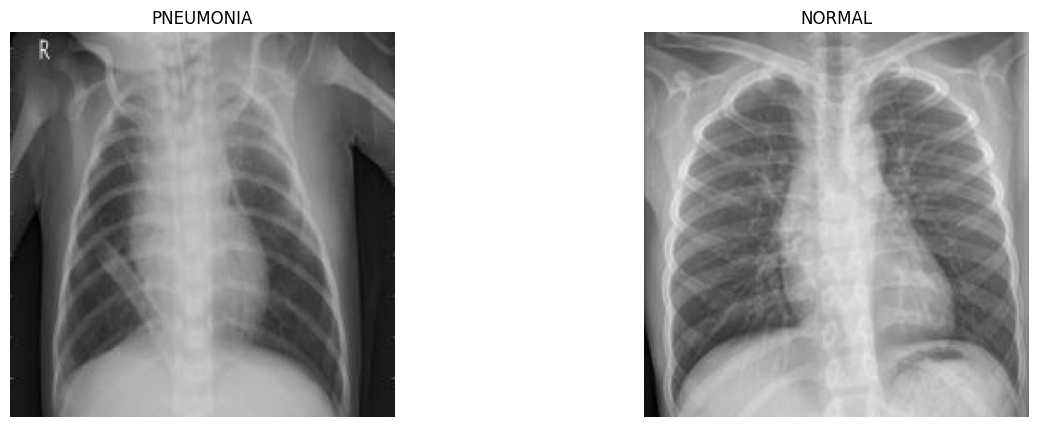

In [6]:
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image
import random

def explore_dataset(root_path):
    splits = ['train', 'valid', 'test']
    data_stats = []

    # 1. Parse Directory Structure
    print(f"Analyzing dataset at: {root_path}...")

    for split in splits:
        split_path = os.path.join(root_path, split)
        if not os.path.exists(split_path):
            print(f"Split '{split}' not found (Roboflow sometimes names valid as 'valid' or 'val')")
            # Try alternative name for validation
            if split == 'valid':
                split_path = os.path.join(root_path, 'val')
                if os.path.exists(split_path):
                    split = 'val'
                else:
                    continue
            else:
                continue

        # Get classes (subfolders)
        classes = [d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, d))]

        for cls in classes:
            class_path = os.path.join(split_path, cls)
            num_images = len(glob.glob(os.path.join(class_path, '*.*')))
            data_stats.append({'Split': split, 'Class': cls, 'Count': num_images})

    df = pd.DataFrame(data_stats)

    # 2. Display Statistics
    if df.empty:
        print("No data found. Check the dataset path.")
        return

    print("\n Dataset Statistics:")
    total_images = df['Count'].sum()
    print(f"Total Images: {total_images}")
    print(f"Classes Detected: {df['Class'].unique()}")
    print("\nBreakdown by Split and Class:")
    print(df.pivot(index='Class', columns='Split', values='Count').fillna(0))

    # 3. Check for Imbalance
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df, x='Class', y='Count', hue='Split')
    plt.title('Class Distribution across Splits')
    plt.xticks(rotation=45)
    plt.show()

    # 4. Visualize Samples
    print("\n Sample Images (One per class from Train split):")
    train_split = 'train'
    classes = df[df['Split'] == train_split]['Class'].unique()

    fig, axes = plt.subplots(1, len(classes), figsize=(15, 5))
    if len(classes) == 1: axes = [axes]

    for i, cls in enumerate(classes):
        cls_path = os.path.join(root_path, train_split, cls)
        images = glob.glob(os.path.join(cls_path, '*.*'))
        if images:
            img_path = random.choice(images)
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].set_title(cls)
            axes[i].axis('off')
    plt.show()

# Run exploration
if 'dataset_path' in locals():
    explore_dataset(dataset_path)
else:
    print("Please download the dataset first.")

## 4. Train YOLO11 Model

In [7]:
from ultralytics import YOLO

model = YOLO('yolo11n-cls.pt')

# Train the model

results = model.train(
    data=dataset_path,
    epochs=20,
    imgsz=224,
    project="skin_disease_project",
    name="yolo11n_skin_cls"
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Jennifer_Week3-1, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=Fals

## 5. Validate and Inference

Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 47 layers, 1,528,586 parameters, 0 gradients, 3.2 GFLOPs
train: /content/Jennifer_Week3-1/train... found 196 images in 2 classes ✅ 
val: /content/Jennifer_Week3-1/valid... found 20 images in 2 classes ✅ 
test: /content/Jennifer_Week3-1/test... found 20 images in 2 classes ✅ 
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 180.1±82.1 MB/s, size: 7.1 KB)
val: Scanning /content/Jennifer_Week3-1/valid... 20 images, 0 corrupt: 100% ━━━━━━━━━━━━ 20/20 40.5Kit/s 0.0s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 2/2 10.5it/s 0.2s
                   all          1          1
Speed: 1.5ms preprocess, 7.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /content/runs/classify/val
Top-1 Accuracy: 1.0
Top-5 Accuracy: 1.0

image 1/1 /content/Jennifer_Week3-1/test/PNEUMONIA/person592_bacteria_2431_jpeg.rf.9ad105d385a58436304e258c3acff477.jpg: 224x22

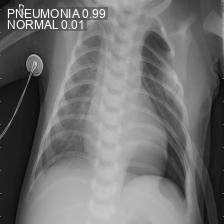

Prediction: PNEUMONIA (0.99)


In [8]:
# Validate on the test/val set automatically included in the dataset folder
metrics = model.val()
print(f"Top-1 Accuracy: {metrics.top1}")
print(f"Top-5 Accuracy: {metrics.top5}")

# Run Inference on a random image from the test set
import glob
import random

test_images = glob.glob(f"{dataset_path}/test/*/*.*")
if test_images:
    test_image = random.choice(test_images)

    # Predict
    results = model.predict(test_image)

    # Show results
    for result in results:
        result.show()  # Display the image with class label
        print(f"Prediction: {result.names[result.probs.top1]} ({result.probs.top1conf:.2f})")
else:
    print("No test images found.")

Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
train: /content/Jennifer_Week3-1/train... found 196 images in 2 classes ✅ 
val: /content/Jennifer_Week3-1/valid... found 20 images in 2 classes ✅ 
test: /content/Jennifer_Week3-1/test... found 20 images in 2 classes ✅ 
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 254.8±98.0 MB/s, size: 7.1 KB)
val: Scanning /content/Jennifer_Week3-1/valid... 20 images, 0 corrupt: 100% ━━━━━━━━━━━━ 20/20 11.1Kit/s 0.0s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 2/2 9.6it/s 0.2s
                   all          1          1
Speed: 1.0ms preprocess, 3.2ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /content/runs/classify/val2
Top-1 Accuracy: 1.0
Top-5 Accuracy: 1.0

image 1/1 /content/Jennifer_Week3-1/test/NORMAL/IM-0394-0001_jpeg.rf.d6b69c4abfeee5db838fc94c4fd07311.jpg: 224x224 NORMAL 1.00, PNEUMONIA 0.00, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 0.1ms postprocess per

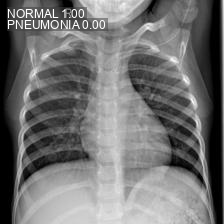

Prediction: NORMAL (1.00)


In [9]:
metrics = model.val()
print(f"Top-1 Accuracy: {metrics.top1}")
print(f"Top-5 Accuracy: {metrics.top5}")

# Run Inference on a random image from the test set
import glob
import random

for i in range(5):
  test_images = glob.glob(f"{dataset_path}/test/*/*.*")
  if test_images:
      test_image = random.choice(test_images)

      # Predict
      results = model.predict(test_image)

      # Show results
      for result in results:
          result.show()  # Display the image with class label
          print(f"Prediction: {result.names[result.probs.top1]} ({result.probs.top1conf:.2f})")
  else:
      print("No test images found.")


Performing inference on 3 random test images:

--- Inference on Image 1 ---

image 1/1 /content/Jennifer_Week3-1/test/PNEUMONIA/person741_virus_1364_jpeg.rf.1eb932b538e89a9ea7b93b13610d7838.jpg: 224x224 PNEUMONIA 1.00, NORMAL 0.00, 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


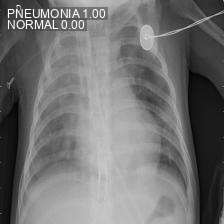

Prediction: PNEUMONIA (Confidence: 1.00)

--- Inference on Image 2 ---

image 1/1 /content/Jennifer_Week3-1/test/NORMAL/NORMAL2-IM-0060-0001_jpeg.rf.40c07622372bdf38bb2f8163b31e48a8.jpg: 224x224 NORMAL 1.00, PNEUMONIA 0.00, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


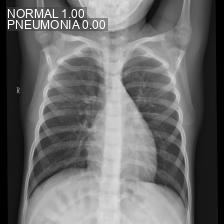

Prediction: NORMAL (Confidence: 1.00)

--- Inference on Image 3 ---

image 1/1 /content/Jennifer_Week3-1/test/NORMAL/IM-0670-0001_jpeg.rf.e88ca0860f4ded1ecabb186df6af26a7.jpg: 224x224 NORMAL 1.00, PNEUMONIA 0.00, 11.0ms
Speed: 1.9ms preprocess, 11.0ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


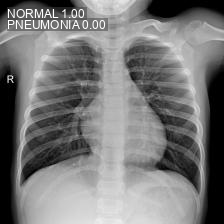

Prediction: NORMAL (Confidence: 1.00)


In [10]:
import glob
import random

# Get all test images
test_images = glob.glob(f"{dataset_path}/test/*/*.*")

if test_images:
    print("\nPerforming inference on 3 random test images:")
    # Select 3 random images for inference
    selected_images = random.sample(test_images, min(3, len(test_images)))

    for i, img_path in enumerate(selected_images):
        print(f"\n--- Inference on Image {i+1} ---")
        # Predict
        results = model.predict(img_path)

        # Show results
        for result in results:
            result.show()  # Display the image with class label
            print(f"Prediction: {result.names[result.probs.top1]} (Confidence: {result.probs.top1conf:.2f})")
else:
    print("No test images found for inference.")

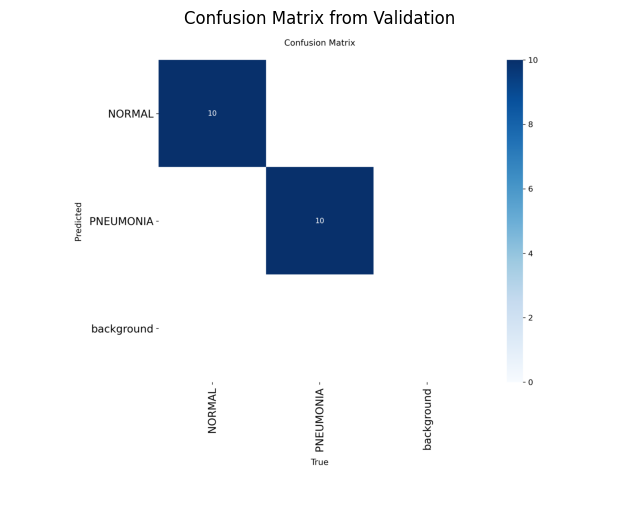

In [11]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# Define the path to the confusion matrix image
confusion_matrix_path = '/content/runs/classify/val2/confusion_matrix.png'

# Check if the image exists
if os.path.exists(confusion_matrix_path):
    # Load the image
    img = Image.open(confusion_matrix_path)

    # Display the image
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title('Confusion Matrix from Validation')
    plt.axis('off') # Hide axes ticks and labels
    plt.show()
else:
    print(f"Error: Confusion matrix not found at {confusion_matrix_path}")
    print("Please ensure the model.val() command was executed successfully and generated the confusion_matrix.png file.")